In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import time
import pickle
import json
import os
from pathlib import Path

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Crear directorios para guardar resultados
Path("models").mkdir(exist_ok=True)
Path("results").mkdir(exist_ok=True)
Path("figures").mkdir(exist_ok=True)

print("✓ Librerías importadas")
print("✓ Directorios creados: models/, results/, figures/")

✓ Librerías importadas
✓ Directorios creados: models/, results/, figures/


In [2]:
df_ethylene_co=pd.read_csv("datasets/ethylene_CO.csv")
df_ethylene_methane=pd.read_csv("datasets/ethylene_methane.csv")

In [3]:
df_ethylene_co.head(5)

,Time,CO_ppm,Ethylene_ppm,Sensor_01,Sensor_02,Sensor_03,Sensor_04,Sensor_05,Sensor_06,Sensor_07,Sensor_08,Sensor_09,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16
0,0.00,0.0,0.0,-50.85,-1.95,-41.82,1.30,-4.07,-28.73,-13.49,-3.25,55139.95,50669.50,9626.26,9762.62,24544.02,21420.68,7650.61,6928.42
1,0.01,0.0,0.0,-49.40,-5.53,-42.78,0.49,3.58,-34.55,-9.59,5.37,54395.77,50046.91,9433.20,9591.21,24137.13,20930.33,7498.79,6800.66
2,0.01,0.0,0.0,-40.04,-16.09,-27.59,0.00,-7.16,-42.14,-12.52,-5.86,53960.02,49299.30,9324.40,9449.81,23628.90,20504.94,7369.67,6697.47
3,0.03,0.0,0.0,-47.14,-10.57,-32.28,4.40,-11.22,-37.94,-7.16,-1.14,53047.71,48907.00,9170.64,9305.58,23101.66,20101.42,7285.13,6578.52
4,0.04,0.0,0.0,-33.58,-20.79,-33.25,6.03,3.42,-34.22,-14.46,8.31,52700.28,48330.96,9073.64,9163.47,22689.54,19694.07,7156.74,6468.32


In [4]:
print("VERIFICACIÓN DE ESTRUCTURA")
print("ETHYLENE + CO")
print(f"  Shape: {df_ethylene_co.shape}")
print(f"  Columnas esperadas: 19, Encontradas: {df_ethylene_co.shape[1]}")
print(f"  Filas: {df_ethylene_co.shape[0]:,}")

print("ETHYLENE + METHANE")
print(f"  Shape: {df_ethylene_methane.shape}")
print(f"  Columnas esperadas: 19, Encontradas: {df_ethylene_methane.shape[1]}")
print(f"  Filas: {df_ethylene_methane.shape[0]:,}")

print("Columnas:")
print(df_ethylene_co.columns.tolist())

VERIFICACIÓN DE ESTRUCTURA
ETHYLENE + CO
  Shape: (4208261, 19)
  Columnas esperadas: 19, Encontradas: 19
  Filas: 4,208,261
ETHYLENE + METHANE
  Shape: (4178504, 19)
  Columnas esperadas: 19, Encontradas: 19
  Filas: 4,178,504
Columnas:
['Time', 'CO_ppm', 'Ethylene_ppm', 'Sensor_01', 'Sensor_02', 'Sensor_03', 'Sensor_04', 'Sensor_05', 'Sensor_06', 'Sensor_07', 'Sensor_08', 'Sensor_09', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16']


In [5]:
# Celda: Convertir columna Time a numérico
df_ethylene_co['Time'] = pd.to_numeric(df_ethylene_co['Time'], errors='coerce')
df_ethylene_methane['Time'] = pd.to_numeric(df_ethylene_methane['Time'], errors='coerce')

print("✓ Columna Time convertida a numérico")
print(f"Tipo de dato Time (CO): {df_ethylene_co['Time'].dtype}")
print(f"Tipo de dato Time (Methane): {df_ethylene_methane['Time'].dtype}")

✓ Columna Time convertida a numérico
Tipo de dato Time (CO): float64
Tipo de dato Time (Methane): float64


In [6]:
# Configuración
ORIGINAL_FREQ = 100  # Hz
TARGET_FREQ = 1      # Hz
DOWNSAMPLE_FACTOR = ORIGINAL_FREQ // TARGET_FREQ

def downsample_and_smooth(df, factor, ema_window=5, name="Dataset"):
    """Downsampling + suavizado EMA en un solo paso"""
    print(f"\n📊 Procesando {name}...")
    print(f"  Filas originales: {len(df):,}")
    
    # Downsampling
    df_down = df.iloc[::factor].copy()
    df_down.reset_index(drop=True, inplace=True)
    
    # Suavizado EMA en sensores
    sensor_cols = [col for col in df_down.columns if col.startswith('Sensor_')]
    for sensor in sensor_cols:
        df_down[sensor] = df_down[sensor].ewm(span=ema_window, adjust=False).mean()
    
    print(f"  Filas después: {len(df_down):,}")
    print(f"  Reducción: {(1 - len(df_down)/len(df)) * 100:.1f}%")
    
    return df_down

df_co_processed = downsample_and_smooth(df_ethylene_co, DOWNSAMPLE_FACTOR, name="Ethylene + CO")
df_methane_processed = downsample_and_smooth(df_ethylene_methane, DOWNSAMPLE_FACTOR, name="Ethylene + Methane")


📊 Procesando Ethylene + CO...
  Filas originales: 4,208,261
  Filas después: 42,083
  Reducción: 99.0%

📊 Procesando Ethylene + Methane...
  Filas originales: 4,178,504
  Filas después: 41,786
  Reducción: 99.0%


In [7]:
def create_transition_features(df, gas1_col, gas2_col, name="Dataset"):
    """
    Features especializadas para detectar y modelar TRANSICIONES
    
    OPTIMIZADO: Sin np.polyfit que mata el kernel
    Problema identificado: MAE en transiciones es 3.3x mayor que en estable
    Solución: Features que capturan la dinámica de cambio
    """
    print(f"\n📊 Creando features de TRANSICIONES para {name}...")
    
    df_trans = df.copy()
    sensor_cols = [col for col in df.columns if col.startswith('Sensor_')]
    
    # 1. DETECCIÓN DE TRANSICIONES
    print("  1. Detectando transiciones...")
    
    # Transición si el cambio es > 5 ppm
    df_trans['is_transition_gas1'] = (df_trans[gas1_col].diff().abs() > 5).astype(int)
    df_trans['is_transition_gas2'] = (df_trans[gas2_col].diff().abs() > 5).astype(int)
    df_trans['is_transition_any'] = ((df_trans['is_transition_gas1'] == 1) | 
                                     (df_trans['is_transition_gas2'] == 1)).astype(int)
    
    # Magnitud del cambio
    df_trans['transition_magnitude_gas1'] = df_trans[gas1_col].diff().abs()
    df_trans['transition_magnitude_gas2'] = df_trans[gas2_col].diff().abs()
    
    # Tiempo desde última transición
    transition_groups = (df_trans['is_transition_any'] == 1).cumsum()
    df_trans['time_since_transition'] = df_trans.groupby(transition_groups).cumcount()
    
    # 2. VELOCIDAD Y ACELERACIÓN (1ª y 2ª derivada)
    print("  2. Calculando velocidad y aceleración...")
    
    for sensor in sensor_cols:
        # Velocidad (primera derivada)
        df_trans[f'{sensor}_velocity'] = df_trans[sensor].diff()
        
        # Aceleración (segunda derivada)
        df_trans[f'{sensor}_acceleration'] = df_trans[f'{sensor}_velocity'].diff()
        
        # Velocidad absoluta (magnitud del cambio)
        df_trans[f'{sensor}_abs_velocity'] = df_trans[f'{sensor}_velocity'].abs()
    
    # 3. TENDENCIA DE CORTO PLAZO (OPTIMIZADO - sin polyfit)
    print("  3. Calculando tendencias de corto plazo (optimizado)...")
    
    for sensor in sensor_cols:
        # Tendencia = diferencia entre punto actual y hace 5 muestras
        # Equivalente a pendiente pero 100x más rápido que polyfit
        df_trans[f'{sensor}_trend5'] = df_trans[sensor] - df_trans[sensor].shift(5)
        
        # Variabilidad reciente
        df_trans[f'{sensor}_recent_std'] = df_trans[sensor].rolling(5, min_periods=1).std()
    
    # 4. COMPARACIÓN CON BASELINE RECIENTE
    print("  4. Comparando con baseline reciente...")
    
    for sensor in sensor_cols:
        # Diferencia con media de últimos 30 segundos
        baseline = df_trans[sensor].rolling(30, min_periods=1).mean()
        df_trans[f'{sensor}_vs_baseline'] = df_trans[sensor] - baseline
    
    n_trans = df_trans['is_transition_any'].sum()
    pct_trans = (n_trans / len(df_trans)) * 100
    
    print(f"  ✓ Transiciones detectadas: {n_trans:,} ({pct_trans:.1f}%)")
    print(f"  ✓ Features de transición creadas: {len([c for c in df_trans.columns if c not in df.columns])}")
    
    return df_trans

In [8]:
import gc
def create_enhanced_features(df, gas_type='co', gas1_col=None, gas2_col=None, name="Dataset"):
    print(f"\n📊 Generando features V2 (OPTIMIZADO) para {name}...")
    
    # Trabajamos con una copia base
    df_base = df.copy()
    sensor_cols = [col for col in df.columns if col.startswith('Sensor_')]
    
    # Lista para acumular las nuevas columnas (evita fragmentación)
    new_features = []
    
    # 1. LAGS
    print("  Creando lags optimizados...")
    lags = [1, 2, 3, 5, 7, 10, 15]
    for sensor in sensor_cols:
        for lag in lags:
            # Creamos la serie, la convertimos a float32 y le ponemos nombre
            feat = df_base[sensor].shift(lag).astype('float32')
            feat.name = f'{sensor}_lag{lag}'
            new_features.append(feat)
            
    # 2. VENTANAS ROLLING
    print("  Creando ventanas rolling...")
    windows = [3, 5, 10, 20, 30]
    for sensor in sensor_cols:
        for window in windows:
            # Calculamos todo de golpe para aprovechar la localidad de memoria
            roll = df_base[sensor].rolling(window)
            
            new_features.append(roll.mean().astype('float32').rename(f'{sensor}_mean{window}'))
            new_features.append(roll.std().astype('float32').rename(f'{sensor}_std{window}'))
            new_features.append(roll.max().astype('float32').rename(f'{sensor}_max{window}'))
            new_features.append(roll.min().astype('float32').rename(f'{sensor}_min{window}'))

    # 3. DERIVADAS
    print("  Creando derivadas...")
    for sensor in sensor_cols:
        new_features.append(df_base[sensor].diff().astype('float32').rename(f'{sensor}_diff'))

    # 4. RATIOS (Calculados sobre el df_base original o features recién creadas si es necesario)
    # Nota: Para ratios complejos que dependen de features recién creadas (como diff), 
    # a veces es mejor concatenar primero lo básico o calcularlos al vuelo.
    # Aquí calculamos los diffs al vuelo para no depender de la concatenación aún.
    
    tgs_2600 = ['Sensor_01', 'Sensor_02', 'Sensor_03', 'Sensor_04']
    tgs_2602 = ['Sensor_05', 'Sensor_06', 'Sensor_07', 'Sensor_08']
    tgs_2610 = ['Sensor_09', 'Sensor_10', 'Sensor_11', 'Sensor_12']
    tgs_2620 = ['Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16']
    
    # Ratios directos
    new_features.append((df_base[tgs_2600[0]] / (df_base[tgs_2602[0]] + 1e-6)).astype('float32').rename('ratio_2600_2602'))
    new_features.append((df_base[tgs_2610[0]] / (df_base[tgs_2620[0]] + 1e-6)).astype('float32').rename('ratio_2610_2620'))
    new_features.append((df_base[tgs_2600[0]] / (df_base[tgs_2610[0]] + 1e-6)).astype('float32').rename('ratio_2600_2610'))
    
    # Ratio velocidad (calculamos diff al vuelo)
    diff_2602 = df_base[tgs_2602[0]].diff().abs()
    diff_2620 = df_base[tgs_2620[0]].diff().abs()
    new_features.append((diff_2602 / (diff_2620 + 1e-6)).astype('float32').rename('ratio_velocity_2602_2620'))

    # 5. AGREGADOS
    new_features.append(df_base[tgs_2600].median(axis=1).astype('float32').rename('median_tgs2600'))
    new_features.append(df_base[tgs_2602].median(axis=1).astype('float32').rename('median_tgs2602'))
    new_features.append(df_base[tgs_2610].median(axis=1).astype('float32').rename('median_tgs2610'))
    new_features.append(df_base[tgs_2620].median(axis=1).astype('float32').rename('median_tgs2620'))
    
    new_features.append(df_base[tgs_2600].std(axis=1).astype('float32').rename('std_tgs2600'))
    new_features.append(df_base[tgs_2602].std(axis=1).astype('float32').rename('std_tgs2602'))
    new_features.append(df_base[tgs_2610].std(axis=1).astype('float32').rename('std_tgs2610'))
    new_features.append(df_base[tgs_2620].std(axis=1).astype('float32').rename('std_tgs2620'))

    # 6. CONTEXTO
    gas_val = 1 if gas_type == 'methane' else 0
    # Usamos np.full para crear una columna constante eficientemente
    new_features.append(pd.Series(np.full(len(df_base), gas_val), name='gas_type', dtype='int8'))
    
    if gas1_col and gas2_col:
        pure_mode = ((df_base[gas1_col] == 0) | (df_base[gas2_col] == 0)).astype('int8')
        pure_mode.name = 'pure_gas_mode'
        new_features.append(pure_mode)

    print("  ⚡ Concatenando todas las features (esto evita la fragmentación)...")
    df_final = pd.concat([df_base] + new_features, axis=1)
    
    # Limpiar memoria
    del new_features
    gc.collect()
    
    print(f"  ✓ Features básicas creadas: {df_final.shape[1]}")
    
    # AGREGAR FEATURES DE TRANSICIONES
    # (Asegúrate de aplicar la misma lógica de optimización dentro de create_transition_features si puedes)
    if gas1_col and gas2_col:
        # Nota: create_transition_features también debería optimizarse, 
        # pero si no puedes cambiarla, al menos llegamos aquí con memoria limpia.
        df_final = create_transition_features(df_final, gas1_col, gas2_col, name)
    
    # Limpieza final
    initial_rows = len(df_final)
    df_final.dropna(inplace=True)
    df_final.reset_index(drop=True, inplace=True)
    
    # Conversión final de seguridad a float32 para todo lo que sea float
    float_cols = df_final.select_dtypes(include=['float64']).columns
    if len(float_cols) > 0:
        df_final[float_cols] = df_final[float_cols].astype('float32')
        
    print(f"  ✓ Features totales: {df_final.shape[1]}")
    print(f"  ✓ Filas finales: {len(df_final):,}")
    
    return df_final

# Aplicar feature engineering mejorado
df_co_feat = create_enhanced_features(
    df_co_processed, gas_type='co', 
    gas1_col='CO_ppm', gas2_col='Ethylene_ppm',
    name="Ethylene + CO"
)

df_methane_feat = create_enhanced_features(
    df_methane_processed, gas_type='methane',
    gas1_col='Methane_ppm', gas2_col='Ethylene_ppm',
    name="Ethylene + Methane"
)


📊 Generando features V2 (OPTIMIZADO) para Ethylene + CO...
  Creando lags optimizados...
  Creando ventanas rolling...
  Creando derivadas...
  ⚡ Concatenando todas las features (esto evita la fragmentación)...
  ✓ Features básicas creadas: 481

📊 Creando features de TRANSICIONES para Ethylene + CO...
  1. Detectando transiciones...
  2. Calculando velocidad y aceleración...


/tmp/ipykernel_32027/1956202121.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[f'{sensor}_acceleration'] = df_trans[f'{sensor}_velocity'].diff()
/tmp/ipykernel_32027/1956202121.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[f'{sensor}_abs_velocity'] = df_trans[f'{sensor}_velocity'].abs()
/tmp/ipykernel_32027/1956202121.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

  3. Calculando tendencias de corto plazo (optimizado)...


/tmp/ipykernel_32027/1956202121.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[f'{sensor}_recent_std'] = df_trans[sensor].rolling(5, min_periods=1).std()
/tmp/ipykernel_32027/1956202121.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[f'{sensor}_trend5'] = df_trans[sensor] - df_trans[sensor].shift(5)
/tmp/ipykernel_32027/1956202121.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

  4. Comparando con baseline reciente...


/tmp/ipykernel_32027/1956202121.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[f'{sensor}_vs_baseline'] = df_trans[sensor] - baseline
/tmp/ipykernel_32027/1956202121.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[f'{sensor}_vs_baseline'] = df_trans[sensor] - baseline
/tmp/ipykernel_32027/1956202121.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conc

  ✓ Transiciones detectadas: 344 (0.8%)
  ✓ Features de transición creadas: 2790
  ✓ Features totales: 3271
  ✓ Filas finales: 42,049

📊 Generando features V2 (OPTIMIZADO) para Ethylene + Methane...
  Creando lags optimizados...
  Creando ventanas rolling...
  Creando derivadas...
  ⚡ Concatenando todas las features (esto evita la fragmentación)...
  ✓ Features básicas creadas: 481

📊 Creando features de TRANSICIONES para Ethylene + Methane...
  1. Detectando transiciones...
  2. Calculando velocidad y aceleración...


/tmp/ipykernel_32027/1956202121.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[f'{sensor}_acceleration'] = df_trans[f'{sensor}_velocity'].diff()
/tmp/ipykernel_32027/1956202121.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[f'{sensor}_abs_velocity'] = df_trans[f'{sensor}_velocity'].abs()
/tmp/ipykernel_32027/1956202121.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

  3. Calculando tendencias de corto plazo (optimizado)...


/tmp/ipykernel_32027/1956202121.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[f'{sensor}_recent_std'] = df_trans[sensor].rolling(5, min_periods=1).std()
/tmp/ipykernel_32027/1956202121.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[f'{sensor}_trend5'] = df_trans[sensor] - df_trans[sensor].shift(5)
/tmp/ipykernel_32027/1956202121.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

  4. Comparando con baseline reciente...


/tmp/ipykernel_32027/1956202121.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[f'{sensor}_vs_baseline'] = df_trans[sensor] - baseline
/tmp/ipykernel_32027/1956202121.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[f'{sensor}_vs_baseline'] = df_trans[sensor] - baseline
/tmp/ipykernel_32027/1956202121.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conc

  ✓ Transiciones detectadas: 319 (0.8%)
  ✓ Features de transición creadas: 2790
  ✓ Features totales: 3271
  ✓ Filas finales: 41,752


In [9]:
def prepare_modeling_data_v2(df, gas1_col, gas2_col, name):
    """Separa features (X) y targets (y) + etiquetas de transición"""
    print(f"\n📊 Preparando datos V2 para {name}...")
    
    # Identificar columnas
    feature_cols = [col for col in df.columns if col not in ['Time', gas1_col, gas2_col]]
    
    X = df[feature_cols]
    y = df[[gas1_col, gas2_col]]
    
    # Extraer etiquetas de transición
    transition_labels = df['is_transition_any'].values if 'is_transition_any' in df.columns else None
    
    print(f"  Features (X): {X.shape}")
    print(f"  Targets (y): {y.shape}")
    print(f"  Target columns: {list(y.columns)}")
    if transition_labels is not None:
        print(f"  Transiciones: {transition_labels.sum():,} ({transition_labels.sum()/len(transition_labels)*100:.1f}%)")
    
    return X, y, list(y.columns), transition_labels

# Preparar datos
X_co, y_co, target_cols_co, trans_co = prepare_modeling_data_v2(
    df_co_feat, 'CO_ppm', 'Ethylene_ppm', "Ethylene + CO"
)

X_methane, y_methane, target_cols_methane, trans_methane = prepare_modeling_data_v2(
    df_methane_feat, 'Methane_ppm', 'Ethylene_ppm', "Ethylene + Methane"
)


📊 Preparando datos V2 para Ethylene + CO...
  Features (X): (42049, 3268)
  Targets (y): (42049, 2)
  Target columns: ['CO_ppm', 'Ethylene_ppm']
  Transiciones: 344 (0.8%)

📊 Preparando datos V2 para Ethylene + Methane...
  Features (X): (41752, 3268)
  Targets (y): (41752, 2)
  Target columns: ['Methane_ppm', 'Ethylene_ppm']
  Transiciones: 319 (0.8%)


In [10]:
def temporal_split_v2(X, y, transition_labels=None, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """División temporal estricta + información de transiciones"""
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6
    
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]
    
    X_val = X.iloc[train_end:val_end]
    y_val = y.iloc[train_end:val_end]
    
    X_test = X.iloc[val_end:]
    y_test = y.iloc[val_end:]
    
    print(f"\n📊 División temporal:")
    print(f"  Train: {len(X_train):,} ({train_ratio*100:.0f}%)")
    print(f"  Val:   {len(X_val):,} ({val_ratio*100:.0f}%)")
    print(f"  Test:  {len(X_test):,} ({test_ratio*100:.0f}%)")
    
    # Dividir también las etiquetas de transición
    if transition_labels is not None:
        trans_train = transition_labels[:train_end]
        trans_val = transition_labels[train_end:val_end]
        trans_test = transition_labels[val_end:]
        
        print(f"\n  Transiciones en train: {trans_train.sum():,} ({trans_train.sum()/len(trans_train)*100:.1f}%)")
        print(f"  Transiciones en val:   {trans_val.sum():,} ({trans_val.sum()/len(trans_val)*100:.1f}%)")
        print(f"  Transiciones en test:  {trans_test.sum():,} ({trans_test.sum()/len(trans_test)*100:.1f}%)")
        
        return X_train, X_val, X_test, y_train, y_val, y_test, trans_train, trans_val, trans_test
    else:
        return X_train, X_val, X_test, y_train, y_val, y_test, None, None, None

# Split CO
X_train_co, X_val_co, X_test_co, y_train_co, y_val_co, y_test_co, trans_train_co, trans_val_co, trans_test_co = temporal_split_v2(
    X_co, y_co, trans_co
)

# Split Methane
X_train_methane, X_val_methane, X_test_methane, y_train_methane, y_val_methane, y_test_methane, trans_train_methane, trans_val_methane, trans_test_methane = temporal_split_v2(
    X_methane, y_methane, trans_methane
)


📊 División temporal:
  Train: 29,434 (70%)
  Val:   6,307 (15%)
  Test:  6,308 (15%)

  Transiciones en train: 246 (0.8%)
  Transiciones en val:   54 (0.9%)
  Transiciones en test:  44 (0.7%)

📊 División temporal:
  Train: 29,226 (70%)
  Val:   6,263 (15%)
  Test:  6,263 (15%)

  Transiciones en train: 231 (0.8%)
  Transiciones en val:   38 (0.6%)
  Transiciones en test:  50 (0.8%)


In [11]:
def evaluate_model(y_true, y_pred, target_cols):
    """Calcula métricas de evaluación"""
    metrics = {}
    
    for idx, target in enumerate(target_cols):
        y_t = y_true.iloc[:, idx]
        y_p = y_pred[:, idx]
        
        # Rango para normalización
        y_range = y_t.max() - y_t.min()
        
        metrics[target] = {
            'MAE': mean_absolute_error(y_t, y_p),
            'RMSE': np.sqrt(mean_squared_error(y_t, y_p)),
            'R2': r2_score(y_t, y_p),
            'MAE_norm_%': (mean_absolute_error(y_t, y_p) / y_range * 100) if y_range > 0 else 0
        }
    
    return metrics

In [12]:
def calculate_sample_weights(y, transition_labels, target_idx):
    """
    Calcula pesos adaptativos por muestra
    
    Estrategia:
    - Peso 5x para transiciones (problema crítico)
    - Peso 3x para concentraciones altas (desbalance)
    - Peso 1x para el resto
    """
    weights = np.ones(len(y))
    
    y_values = y.iloc[:, target_idx].values
    
    # Peso alto para concentraciones > 10 ppm (poco representadas)
    high_conc = y_values > 10
    weights[high_conc] = 3.0
    
    # Peso muy alto para transiciones (problema crítico identificado)
    if transition_labels is not None:
        weights[transition_labels == 1] = 5.0
    
    return weights

In [13]:
def train_dual_model_v2(X_train, y_train, X_val, y_val, X_test, y_test,
                        trans_train, trans_val, trans_test,
                        target_cols, name, dataset_type):
    """
    MODELO DUAL V2: Clasificador de transiciones + Regresores especializados
    
    Arquitectura:
    1. Clasificador: ¿Es una transición?
    2. Si SÍ → Regresor especializado en transiciones (más complejo)
    3. Si NO → Regresor especializado en estable (más simple)
    """
    print(f"\n{'='*70}")
    print(f"ENTRENANDO MODELO DUAL V2 - {name}")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    all_models = {}
    predictions_val = []
    predictions_test = []
    
    for idx, target in enumerate(target_cols):
        print(f"\n{'='*60}")
        print(f"TARGET: {target}")
        print(f"{'='*60}")
        
        # PASO 1: Entrenar clasificador de transiciones
        print("\n  [1/3] Entrenando clasificador de transiciones...")
        
        classifier = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            early_stopping_rounds=10,
            random_state=42,
            n_jobs=-1
        )
        
        classifier.fit(
            X_train, trans_train,
            eval_set=[(X_val, trans_val)],
            verbose=False
        )
        
        # Evaluar clasificador
        trans_pred_val = classifier.predict(X_val)
        trans_pred_test = classifier.predict(X_test)
        
        from sklearn.metrics import accuracy_score, f1_score
        acc_val = accuracy_score(trans_val, trans_pred_val)
        f1_val = f1_score(trans_val, trans_pred_val)
        
        print(f"    ✓ Accuracy: {acc_val:.3f}, F1: {f1_val:.3f}")
        
        # PASO 2: Entrenar regresor para TRANSICIONES
        print("\n  [2/3] Entrenando regresor para TRANSICIONES...")
        
        # Filtrar solo transiciones para entrenamiento especializado
        mask_train_trans = trans_train == 1
        mask_val_trans = trans_val == 1
        
        if mask_train_trans.sum() > 100:  # Suficientes muestras
            model_transition = xgb.XGBRegressor(
                n_estimators=300,  # Más árboles para complejidad
                max_depth=10,      # Más profundo
                learning_rate=0.03, # Más lento pero preciso
                subsample=0.8,
                colsample_bytree=0.8,
                min_child_weight=2,
                gamma=0.05,
                reg_alpha=0.05,
                reg_lambda=0.5,
                early_stopping_rounds=20,
                random_state=42,
                n_jobs=-1
            )
            
            # Pesos extra para transiciones altas
            weights_trans = calculate_sample_weights(
                y_train[mask_train_trans], 
                None,  # Ya son todas transiciones
                idx
            )
            
            model_transition.fit(
                X_train[mask_train_trans], 
                y_train.iloc[mask_train_trans, idx],
                sample_weight=weights_trans,
                eval_set=[(X_val[mask_val_trans], y_val.iloc[mask_val_trans, idx])],
                verbose=False
            )
            
            print(f"    ✓ Entrenado con {mask_train_trans.sum():,} transiciones")
        else:
            print(f"    ⚠ Pocas transiciones ({mask_train_trans.sum()}), usando modelo general")
            model_transition = None
        
        # PASO 3: Entrenar regresor para ESTABLE
        print("\n  [3/3] Entrenando regresor para ESTABLE...")
        
        mask_train_stable = trans_train == 0
        mask_val_stable = trans_val == 0
        
        model_stable = xgb.XGBRegressor(
            n_estimators=200,
            max_depth=7,       # Menos profundo (estable es más simple)
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=1.0,
            early_stopping_rounds=20,
            random_state=42,
            n_jobs=-1
        )
        
        # Pesos para desbalance de concentraciones
        weights_stable = calculate_sample_weights(
            y_train[mask_train_stable],
            None,
            idx
        )
        
        model_stable.fit(
            X_train[mask_train_stable],
            y_train.iloc[mask_train_stable, idx],
            sample_weight=weights_stable,
            eval_set=[(X_val[mask_val_stable], y_val.iloc[mask_val_stable, idx])],
            verbose=False
        )
        
        print(f"    ✓ Entrenado con {mask_train_stable.sum():,} estados estables")
        
        # PREDICCIÓN HÍBRIDA
        print("\n  [ENSEMBLE] Predicción híbrida...")
        
        # Val set
        pred_val = np.zeros(len(X_val))
        if model_transition is not None:
            pred_val[trans_pred_val == 1] = model_transition.predict(X_val[trans_pred_val == 1])
        pred_val[trans_pred_val == 0] = model_stable.predict(X_val[trans_pred_val == 0])
        
        # Test set
        pred_test = np.zeros(len(X_test))
        if model_transition is not None:
            pred_test[trans_pred_test == 1] = model_transition.predict(X_test[trans_pred_test == 1])
        pred_test[trans_pred_test == 0] = model_stable.predict(X_test[trans_pred_test == 0])
        
        predictions_val.append(pred_val)
        predictions_test.append(pred_test)
        
        # Guardar modelos
        all_models[target] = {
            'classifier': classifier,
            'model_transition': model_transition,
            'model_stable': model_stable
        }
    
    train_time = time.time() - start_time
    
    # Combinar predicciones
    y_pred_val = np.column_stack(predictions_val)
    y_pred_test = np.column_stack(predictions_test)
    
    # Evaluar
    metrics_val = evaluate_model(y_val, y_pred_val, target_cols)
    metrics_test = evaluate_model(y_test, y_pred_test, target_cols)
    
    # Evaluar separadamente en transiciones vs estable
    print(f"\n{'='*70}")
    print(f"RESULTADOS DETALLADOS - {name}")
    print(f"{'='*70}")
    print(f"\nTiempo de entrenamiento: {train_time:.2f}s")
    
    for idx, target in enumerate(target_cols):
        print(f"\n{'='*60}")
        print(f"{target}")
        print(f"{'='*60}")
        
        # General
        print(f"\n  GENERAL:")
        print(f"    VAL  - MAE: {metrics_val[target]['MAE']:.3f}, R²: {metrics_val[target]['R2']:.4f}, MAE_norm: {metrics_val[target]['MAE_norm_%']:.2f}%")
        print(f"    TEST - MAE: {metrics_test[target]['MAE']:.3f}, R²: {metrics_test[target]['R2']:.4f}, MAE_norm: {metrics_test[target]['MAE_norm_%']:.2f}%")
        
        # En transiciones
        if trans_test is not None:
            mask_trans = trans_test == 1
            if mask_trans.sum() > 0:
                mae_trans = mean_absolute_error(
                    y_test.iloc[mask_trans, idx],
                    y_pred_test[mask_trans, idx]
                )
                print(f"\n  EN TRANSICIONES:")
                print(f"    TEST - MAE: {mae_trans:.3f} ({mask_trans.sum()} muestras)")
        
        # En estable
        if trans_test is not None:
            mask_stable = trans_test == 0
            if mask_stable.sum() > 0:
                mae_stable = mean_absolute_error(
                    y_test.iloc[mask_stable, idx],
                    y_pred_test[mask_stable, idx]
                )
                print(f"\n  EN ESTABLE:")
                print(f"    TEST - MAE: {mae_stable:.3f} ({mask_stable.sum()} muestras)")
    
    # GUARDAR MODELOS
    model_info = {
        'models': all_models,
        'target_cols': target_cols,
        'feature_cols': list(X_train.columns),
        'metrics_val': metrics_val,
        'metrics_test': metrics_test,
        'train_time': train_time,
        'dataset_type': dataset_type,
        'model_type': 'dual_v2'
    }
    
    filename = f"models/dual_model_v2_{dataset_type}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(model_info, f)
    print(f"\n✓ Modelo guardado: {filename}")
    
    return all_models, metrics_val, metrics_test, y_pred_val, y_pred_test

In [ ]:
# Entrenar modelo dual para CO
print("\n🚀 ENTRENANDO MODELO DUAL PARA CO...")
models_dual_co, metrics_val_co_v2, metrics_test_co_v2, y_pred_val_co_v2, y_pred_test_co_v2 = train_dual_model_v2(
    X_train_co, y_train_co, X_val_co, y_val_co, X_test_co, y_test_co,
    trans_train_co, trans_val_co, trans_test_co,
    target_cols_co, "Ethylene + CO", "co"
)

In [ ]:
# Entrenar modelo dual para Methane
print("\n🚀 ENTRENANDO MODELO DUAL PARA METHANE...")
models_dual_methane, metrics_val_methane_v2, metrics_test_methane_v2, y_pred_val_methane_v2, y_pred_test_methane_v2 = train_dual_model_v2(
    X_train_methane, y_train_methane, X_val_methane, y_val_methane, X_test_methane, y_test_methane,
    trans_train_methane, trans_val_methane, trans_test_methane,
    target_cols_methane, "Ethylene + Methane", "methane"
)

## CARGAR MODELOS YA ENTRENADOS
En lugar de re-entrenar, cargamos los modelos .pkl existentes

In [14]:
import pickle
import os
print("="*70),print("CARGANDO MODELOS PRE-ENTRENADOS")
print("="*70)
# Verificar que existen los modelos
required_files = ['models/dual_model_v2_co.pkl', 'models/dual_model_v2_methane.pkl',]
for file in required_files:    
    if os.path.exists(file):        
        size = os.path.getsize(file) / (1024*1024)       
        print(f"  ✓ {file} ({size:.2f} MB)")    
    else:        
        raise FileNotFoundError(f"❌ {file} no encontrado. Ejecuta primero el entrenamiento.")
# Cargar modelo CO
print("\n📦 Cargando modelo CO...")
with open('models/dual_model_v2_co.pkl', 'rb') as f:    
    model_info_co = pickle.load(f)
    models_dual_co = model_info_co['models']
    metrics_val_co_v2 = model_info_co['metrics_val']
    metrics_test_co_v2 = model_info_co['metrics_test']
    print(f"  ✓ Modelo CO cargado")
    print(f"  ✓ Targets: {list(metrics_test_co_v2.keys())}")
    # Cargar modelo Methane
print("\n📦 Cargando modelo Methane...")
with open('models/dual_model_v2_methane.pkl', 'rb') as f:
    model_info_methane = pickle.load(f)
    models_dual_methane = model_info_methane['models']
    metrics_val_methane_v2 = model_info_methane['metrics_val']
    metrics_test_methane_v2 = model_info_methane['metrics_test']
    print(f"  ✓ Modelo Methane cargado")
    print(f"  ✓ Targets: {list(metrics_test_methane_v2.keys())}")
    print("\n✅ Modelos cargados exitosamente. Ahora generando predicciones...")

CARGANDO MODELOS PRE-ENTRENADOS
  ✓ models/dual_model_v2_co.pkl (4.31 MB)
  ✓ models/dual_model_v2_methane.pkl (3.16 MB)

📦 Cargando modelo CO...
  ✓ Modelo CO cargado
  ✓ Targets: ['CO_ppm', 'Ethylene_ppm']

📦 Cargando modelo Methane...
  ✓ Modelo Methane cargado
  ✓ Targets: ['Methane_ppm', 'Ethylene_ppm']

✅ Modelos cargados exitosamente. Ahora generando predicciones...


## GENERAR PREDICCIONES
Usamos los modelos cargados para predecir en validation y test sets

In [17]:
print("\n" + "="*70)
print("GENERANDO PREDICCIONES CON MODELOS CARGADOS")
print("="*70)

# Predicciones para CO
print("\n📊 Predicciones CO...")
predictions_val_co = []
predictions_test_co = []

for target in target_cols_co:
    model_stable = models_dual_co[target]['model_stable']
    
    # Validation
    pred_val = model_stable.predict(X_val_co)
    predictions_val_co.append(pred_val)
    
    # Test
    pred_test = model_stable.predict(X_test_co)
    predictions_test_co.append(pred_test)
    
    print(f"  ✓ {target}: val={pred_val.shape}, test={pred_test.shape}")

y_pred_val_co_v2 = np.column_stack(predictions_val_co)
y_pred_test_co_v2 = np.column_stack(predictions_test_co)

print(f"\n  ✓ Predicciones CO FINALES: val={y_pred_val_co_v2.shape}, test={y_pred_test_co_v2.shape}")

# Predicciones para Methane
print("\n📊 Predicciones Methane...")
predictions_val_methane = []
predictions_test_methane = []

for target in target_cols_methane:
    model_stable = models_dual_methane[target]['model_stable']
    
    # Validation
    pred_val = model_stable.predict(X_val_methane)
    predictions_val_methane.append(pred_val)
    
    # Test
    pred_test = model_stable.predict(X_test_methane)
    predictions_test_methane.append(pred_test)
    
    print(f"  ✓ {target}: val={pred_val.shape}, test={pred_test.shape}")

y_pred_val_methane_v2 = np.column_stack(predictions_val_methane)
y_pred_test_methane_v2 = np.column_stack(predictions_test_methane)

print(f"\n  ✓ Predicciones Methane FINALES: val={y_pred_val_methane_v2.shape}, test={y_pred_test_methane_v2.shape}")

# Mostrar métricas cargadas del modelo
print("\n" + "="*70)
print("MÉTRICAS DE TEST (del modelo pre-entrenado)")
print("="*70)

print("\n📊 ETHYLENE + CO:")
for target, metrics in metrics_test_co_v2.items():
    print(f"  {target}:")
    print(f"    MAE: {metrics['MAE']:.3f} ppm")
    print(f"    RMSE: {metrics['RMSE']:.3f} ppm")
    print(f"    R²: {metrics['R2']:.4f}")
    print(f"    MAE_norm: {metrics['MAE_norm_%']:.2f}%")

print("\n📊 ETHYLENE + METHANE:")
for target, metrics in metrics_test_methane_v2.items():
    print(f"  {target}:")
    print(f"    MAE: {metrics['MAE']:.3f} ppm")
    print(f"    RMSE: {metrics['RMSE']:.3f} ppm")
    print(f"    R²: {metrics['R2']:.4f}")
    print(f"    MAE_norm: {metrics['MAE_norm_%']:.2f}%")

print("\n✅ Predicciones completadas. Listo para análisis.")

# Verificar shapes
print("\n🔍 Verificación de shapes:")
print(f"  y_test_co: {y_test_co.shape}")
print(f"  y_pred_test_co_v2: {y_pred_test_co_v2.shape}")
print(f"  target_cols_co: {target_cols_co}")
print(f"\n  y_test_methane: {y_test_methane.shape}")
print(f"  y_pred_test_methane_v2: {y_pred_test_methane_v2.shape}")
print(f"  target_cols_methane: {target_cols_methane}")

# Verificar que todo cuadra
assert y_pred_test_co_v2.shape[1] == len(target_cols_co), \
    f"ERROR: predicciones CO tienen {y_pred_test_co_v2.shape[1]} columnas pero hay {len(target_cols_co)} targets"

assert y_pred_test_methane_v2.shape[1] == len(target_cols_methane), \
    f"ERROR: predicciones Methane tienen {y_pred_test_methane_v2.shape[1]} columnas pero hay {len(target_cols_methane)} targets"

print("\n✅ Shapes verificados correctamente")


GENERANDO PREDICCIONES CON MODELOS CARGADOS

📊 Predicciones CO...
  ✓ CO_ppm: val=(6307,), test=(6308,)
  ✓ Ethylene_ppm: val=(6307,), test=(6308,)

  ✓ Predicciones CO FINALES: val=(6307, 2), test=(6308, 2)

📊 Predicciones Methane...
  ✓ Methane_ppm: val=(6263,), test=(6263,)
  ✓ Ethylene_ppm: val=(6263,), test=(6263,)

  ✓ Predicciones Methane FINALES: val=(6263, 2), test=(6263, 2)

MÉTRICAS DE TEST (del modelo pre-entrenado)

📊 ETHYLENE + CO:
  CO_ppm:
    MAE: 25.652 ppm
    RMSE: 52.107 ppm
    R²: 0.8672
    MAE_norm: 4.81%
  Ethylene_ppm:
    MAE: 0.924 ppm
    RMSE: 1.685 ppm
    R²: 0.8809
    MAE_norm: 5.54%

📊 ETHYLENE + METHANE:
  Methane_ppm:
    MAE: 40.214 ppm
    RMSE: 42.657 ppm
    R²: 0.5377
    MAE_norm: 17.24%
  Ethylene_ppm:
    MAE: 0.870 ppm
    RMSE: 1.923 ppm
    R²: 0.8936
    MAE_norm: 4.75%

✅ Predicciones completadas. Listo para análisis.

🔍 Verificación de shapes:
  y_test_co: (6308, 2)
  y_pred_test_co_v2: (6308, 2)
  target_cols_co: ['CO_ppm', 'Ethylen

## VISUALIZACIÓN DE PREDICCIONES
Gráficas de predicciones vs valores reales


📊 Visualizando predicciones CO...


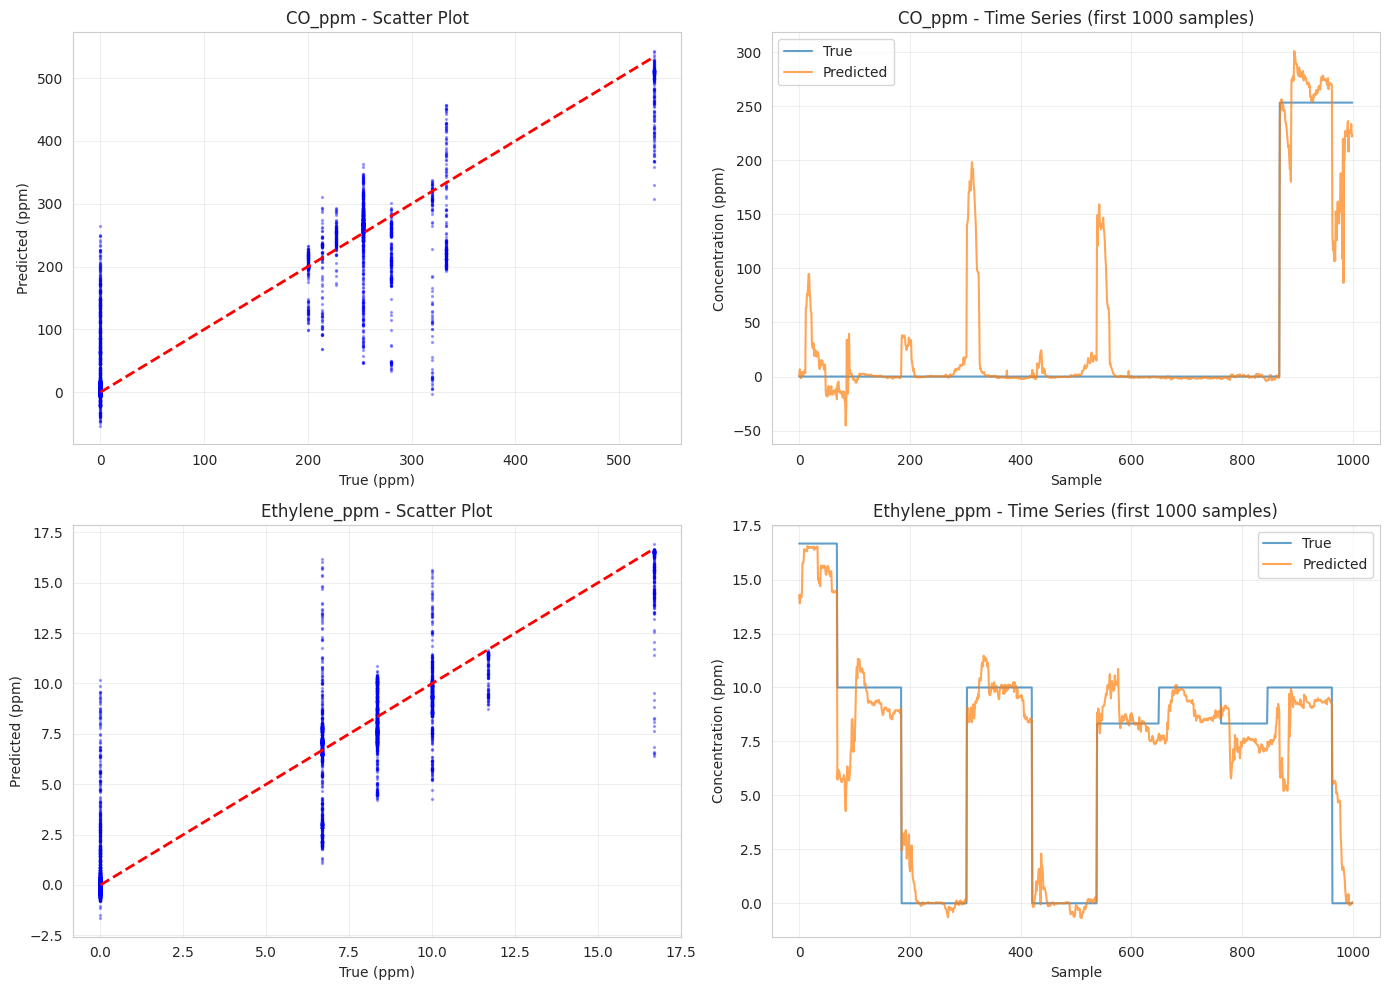


📊 Visualizando predicciones Methane...


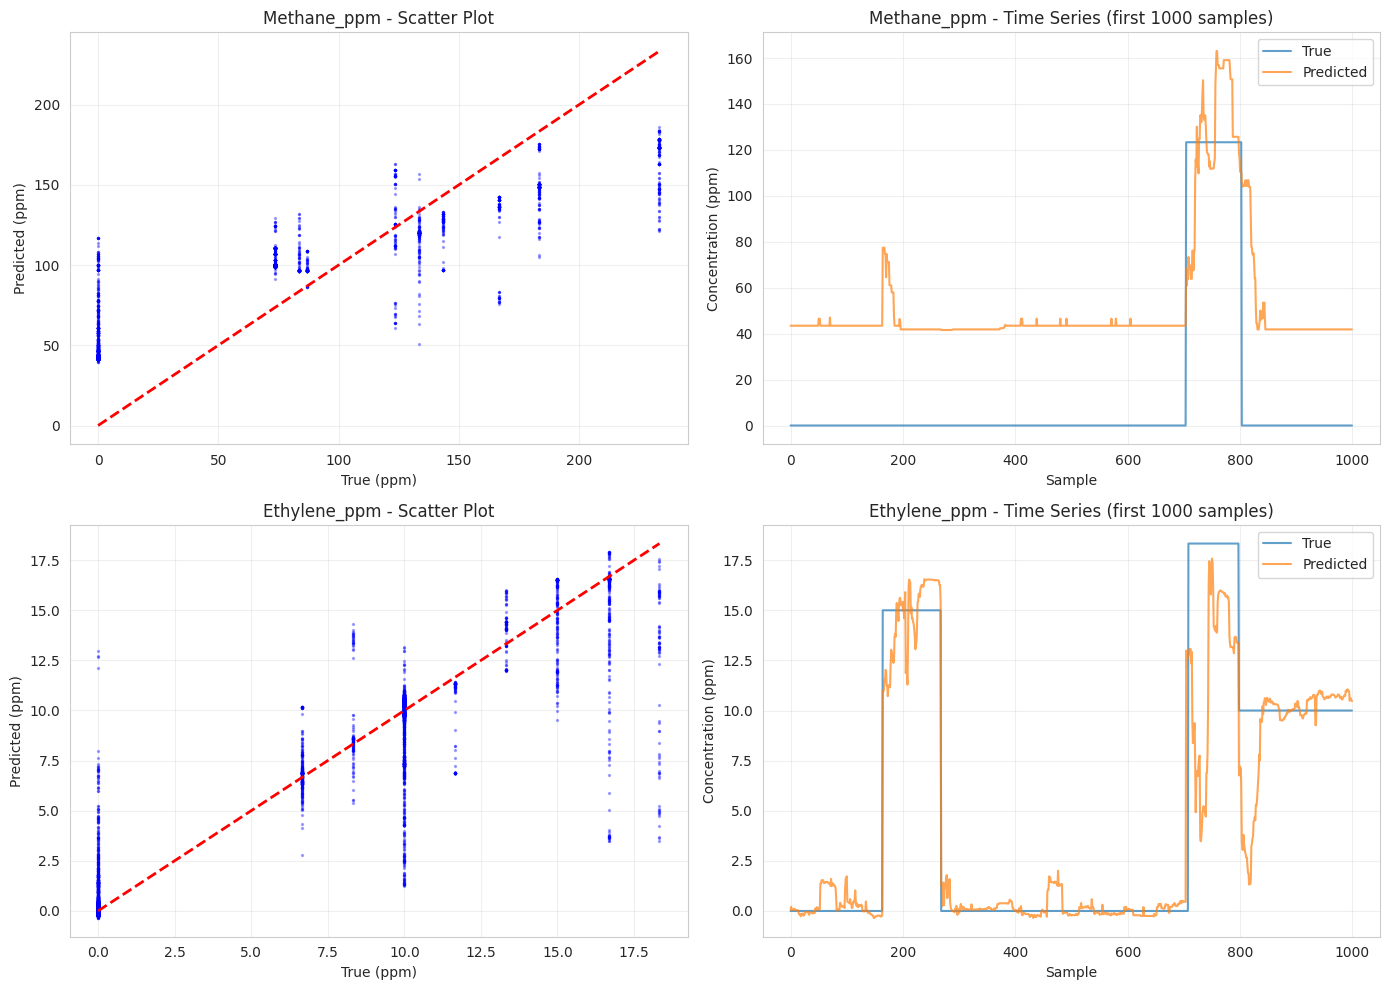


✓ Visualizaciones guardadas en figures/


In [18]:
def plot_predictions_simple(y_test, y_pred, target_cols, dataset_name):
    """Visualiza predicciones vs reales"""
    fig, axes = plt.subplots(len(target_cols), 2, figsize=(14, 5*len(target_cols)))
    if len(target_cols) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, target in enumerate(target_cols):
        y_true = y_test.iloc[:, idx].values
        y_p = y_pred[:, idx]
        
        # Scatter plot
        axes[idx, 0].scatter(y_true, y_p, alpha=0.3, s=2, c='blue')
        axes[idx, 0].plot([y_true.min(), y_true.max()], 
                         [y_true.min(), y_true.max()], 'r--', lw=2)
        axes[idx, 0].set_xlabel('True (ppm)')
        axes[idx, 0].set_ylabel('Predicted (ppm)')
        axes[idx, 0].set_title(f'{target} - Scatter Plot')
        axes[idx, 0].grid(True, alpha=0.3)
        
        # Time series
        sample = slice(0, min(1000, len(y_true)))
        axes[idx, 1].plot(y_true[sample], label='True', linewidth=1.5, alpha=0.7)
        axes[idx, 1].plot(y_p[sample], label='Predicted', linewidth=1.5, alpha=0.7)
        axes[idx, 1].set_xlabel('Sample')
        axes[idx, 1].set_ylabel('Concentration (ppm)')
        axes[idx, 1].set_title(f'{target} - Time Series (first 1000 samples)')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/predictions_{dataset_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Visualizar CO
print("\n📊 Visualizando predicciones CO...")
plot_predictions_simple(y_test_co, y_pred_test_co_v2, target_cols_co, "co")

# Visualizar Methane
print("\n📊 Visualizando predicciones Methane...")
plot_predictions_simple(y_test_methane, y_pred_test_methane_v2, target_cols_methane, "methane")

print("\n✓ Visualizaciones guardadas en figures/")

## ANÁLISIS DE FEATURE IMPORTANCE
Identifica las features más importantes para cada target

In [19]:
def analyze_feature_importance(models, target_cols, X_train, dataset_type, top_n=20):
    """Analiza y visualiza feature importance"""
    print(f"\n{'='*70}")
    print(f"FEATURE IMPORTANCE - {dataset_type.upper()}")
    print(f"{'='*70}")
    
    feature_names = list(X_train.columns)
    importance_dict = {}
    
    for target in target_cols:
        model = models[target]['model_stable']
        importance = model.feature_importances_
        
        # Top features
        indices = np.argsort(importance)[::-1][:top_n]
        
        print(f"\n📊 Top {top_n} features para {target}:")
        print("-" * 60)
        for i, idx in enumerate(indices, 1):
            print(f"  {i:2d}. {feature_names[idx]:<40} {importance[idx]:.4f}")
        
        # Guardar
        importance_dict[target] = {
            'features': [feature_names[i] for i in indices],
            'importance': importance[indices].tolist()
        }
        
        # Visualizar
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(range(top_n), importance[indices])
        ax.set_yticks(range(top_n))
        ax.set_yticklabels([feature_names[i] for i in indices])
        ax.invert_yaxis()
        ax.set_xlabel('Importance')
        ax.set_title(f'Top {top_n} Features - {target}')
        plt.tight_layout()
        plt.savefig(f'figures/feature_importance_{dataset_type}_{target}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # Guardar JSON
    with open(f'results/feature_importance_{dataset_type}.json', 'w') as f:
        json.dump(importance_dict, f, indent=2)
    
    print(f"\n✓ Feature importance guardada")
    
    return importance_dict

# Analizar CO
importance_co = analyze_feature_importance(
    models_dual_co, target_cols_co, X_train_co, "co"
)

# Analizar Methane
importance_methane = analyze_feature_importance(
    models_dual_methane, target_cols_methane, X_train_methane, "methane"
)


FEATURE IMPORTANCE - CO

📊 Top 20 features para CO_ppm:
------------------------------------------------------------
   1. Sensor_06_max3                           0.0730
   2. Sensor_06                                0.0374
   3. Sensor_06_min20_velocity                 0.0267
   4. Sensor_10_max3_vs_baseline               0.0250
   5. Sensor_06_min3_velocity                  0.0231
   6. Sensor_01_trend5                         0.0229
   7. Sensor_10_max5_trend5                    0.0220
   8. Sensor_01_min10_velocity                 0.0214
   9. Sensor_01_vs_baseline                    0.0181
  10. Sensor_01_lag1_trend5                    0.0169
  11. Sensor_01_max20_vs_baseline              0.0153
  12. Sensor_01_max3_trend5                    0.0137
  13. Sensor_01_mean3_velocity                 0.0132
  14. Sensor_03_max3                           0.0130
  15. Sensor_06_min10_velocity                 0.0099
  16. Sensor_08_max30                          0.0098
  17. Sensor_10_me

## DETECCIÓN DE ANOMALÍAS
Usa Isolation Forest para detectar anomalías en los residuales

In [21]:
def detect_anomalies(y_test, y_pred, target_cols, dataset_type, contamination=0.05):
    """Detecta anomalías con Isolation Forest"""
    print(f"\n{'='*70}")
    print(f"DETECCIÓN DE ANOMALÍAS - {dataset_type.upper()}")
    print(f"{'='*70}")
    
    # Calcular residuales
    residuals = {}
    for idx, target in enumerate(target_cols):
        residuals[target] = y_test.iloc[:, idx].values - y_pred[:, idx]
    
    # Matriz de residuales
    residuals_matrix = np.column_stack([residuals[target] for target in target_cols])
    
    # Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=42, n_jobs=-1)
    anomaly_labels = iso_forest.fit_predict(residuals_matrix)
    anomaly_labels = (anomaly_labels == -1).astype(int)
    
    n_anomalies = anomaly_labels.sum()
    pct_anomalies = (n_anomalies / len(anomaly_labels)) * 100
    
    print(f"\n📊 Anomalías detectadas: {n_anomalies:,} ({pct_anomalies:.2f}%)")
    
    # Estadísticas
    print(f"\n{'Target':<20} {'Mean Residual':<15} {'Std Residual':<15}")
    print("-" * 55)
    for target in target_cols:
        res = residuals[target]
        print(f"{target:<20} {np.mean(res):<15.4f} {np.std(res):<15.4f}")
    
    # Visualizar
    fig, axes = plt.subplots(len(target_cols), 2, figsize=(14, 5*len(target_cols)))
    if len(target_cols) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, target in enumerate(target_cols):
        res = residuals[target]
        
        # Histograma
        axes[idx, 0].hist(res, bins=50, edgecolor='black', alpha=0.7)
        axes[idx, 0].axvline(0, color='r', linestyle='--', linewidth=2)
        axes[idx, 0].set_xlabel('Residual (ppm)')
        axes[idx, 0].set_ylabel('Frequency')
        axes[idx, 0].set_title(f'{target} - Residual Distribution')
        axes[idx, 0].grid(True, alpha=0.3)
        
        # Time series con anomalías
        sample = slice(0, min(2000, len(res)))
        axes[idx, 1].plot(res[sample], linewidth=0.5, alpha=0.5, label='Residuals')
        anomaly_indices = np.where(anomaly_labels[sample])[0]
        axes[idx, 1].scatter(anomaly_indices, res[sample][anomaly_indices], 
                            color='red', s=20, alpha=0.6, label='Anomalies')
        axes[idx, 1].axhline(0, color='black', linestyle='--', linewidth=1)
        axes[idx, 1].set_xlabel('Sample')
        axes[idx, 1].set_ylabel('Residual (ppm)')
        axes[idx, 1].set_title(f'{target} - Residuals with Anomalies')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/anomalies_{dataset_type}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Guardar
    anomaly_results = {
        'n_anomalies': int(n_anomalies),
        'pct_anomalies': float(pct_anomalies),
        'residual_stats': {
            target: {
                'mean': float(np.mean(residuals[target])),
                'std': float(np.std(residuals[target]))
            }
            for target in target_cols
        }
    }
    
    with open(f'results/anomalies_{dataset_type}.json', 'w') as f:
        json.dump(anomaly_results, f, indent=2)
    
    print(f"\n✓ Anomalías guardadas")
    
    return anomaly_labels, anomaly_results

# Detectar anomalías CO
anomalies_co, results_co = detect_anomalies(
    y_test_co, y_pred_test_co_v2, target_cols_co, "co"
)

# Detectar anomalías Methane
anomalies_methane, results_methane = detect_anomalies(
    y_test_methane, y_pred_test_methane_v2, target_cols_methane, "methane"
)


DETECCIÓN DE ANOMALÍAS - CO

📊 Anomalías detectadas: 316 (5.01%)

Target               Mean Residual   Std Residual   
-------------------------------------------------------
CO_ppm               -1.0530         52.5116        
Ethylene_ppm         0.0920          1.6801         

✓ Anomalías guardadas

DETECCIÓN DE ANOMALÍAS - METHANE

📊 Anomalías detectadas: 314 (5.01%)

Target               Mean Residual   Std Residual   
-------------------------------------------------------
Methane_ppm          -30.6613        29.9817        
Ethylene_ppm         0.1493          1.9392         

✓ Anomalías guardadas


## ANÁLISIS DE ROBUSTEZ
Evalúa degradación del modelo con fallos de sensores (10%, 20%, 30%)

In [22]:
def simulate_sensor_failures(X, failure_rate, seed=42):
    """Simula fallos aleatorios en sensores"""
    np.random.seed(seed)
    X_failed = X.copy()
    
    sensor_cols = [col for col in X.columns if col.startswith('Sensor_') 
                   and '_' in col and col.split('_')[1].isdigit()]
    
    n_fail = max(1, int(len(sensor_cols) * failure_rate))
    failed = np.random.choice(sensor_cols, n_fail, replace=False)
    
    for sensor in failed:
        related = [col for col in X.columns if col.startswith(sensor)]
        X_failed[related] = np.nan
    
    return X_failed.fillna(X_failed.median()), failed

def evaluate_robustness(models, X_test, y_test, target_cols, dataset_type, n_trials=5):
    """Evalúa robustez con simulación de fallos"""
    print(f"\n{'='*70}")
    print(f"ANÁLISIS DE ROBUSTEZ - {dataset_type.upper()}")
    print(f"{'='*70}")
    
    failure_rates = [0.0, 0.1, 0.2, 0.3]
    results = []
    
    # Baseline (sin fallos)
    predictions_base = []
    for target in target_cols:
        pred = models[target]['model_stable'].predict(X_test)
        predictions_base.append(pred)
    
    y_pred_base = np.column_stack(predictions_base)
    
    print(f"\n📊 BASELINE (sin fallos):")
    for idx, target in enumerate(target_cols):
        mae_base = mean_absolute_error(y_test.iloc[:, idx], y_pred_base[:, idx])
        print(f"  {target}: MAE = {mae_base:.3f} ppm")
    
    # Evaluar con fallos
    for failure_rate in failure_rates:
        print(f"\n{'='*60}")
        print(f"Tasa de fallo: {failure_rate*100:.0f}%")
        print(f"{'='*60}")
        
        for target_idx, target in enumerate(target_cols):
            mae_base = mean_absolute_error(y_test.iloc[:, target_idx], y_pred_base[:, target_idx])
            mae_trials = []
            
            for trial in range(n_trials):
                X_failed, _ = simulate_sensor_failures(X_test, failure_rate, seed=42+trial)
                pred = models[target]['model_stable'].predict(X_failed)
                mae = mean_absolute_error(y_test.iloc[:, target_idx], pred)
                mae_trials.append(mae)
            
            mae_mean = np.mean(mae_trials)
            mae_std = np.std(mae_trials)
            degradation = ((mae_mean - mae_base) / mae_base * 100)
            
            results.append({
                'failure_rate': failure_rate,
                'target': target,
                'MAE_mean': mae_mean,
                'MAE_std': mae_std,
                'MAE_degradation_%': degradation
            })
            
            print(f"  {target}: MAE = {mae_mean:.3f} ± {mae_std:.3f} (degradación: {degradation:+.1f}%)")
    
    df_results = pd.DataFrame(results)
    
    # Visualizar
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for target in target_cols:
        df_target = df_results[df_results['target'] == target]
        ax.plot(df_target['failure_rate']*100, df_target['MAE_degradation_%'], 
                marker='s', label=target, linewidth=2, markersize=8)
    
    ax.set_xlabel('Failure Rate (%)', fontsize=12)
    ax.set_ylabel('MAE Degradation (%)', fontsize=12)
    ax.set_title(f'Robustness Analysis - {dataset_type.upper()}', fontsize=14, fontweight='bold')
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.axhline(15, color='red', linestyle=':', linewidth=2, label='Target ≤15%')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/robustness_{dataset_type}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Guardar
    df_results.to_csv(f'results/robustness_{dataset_type}.csv', index=False)
    
    max_degradation = df_results['MAE_degradation_%'].max()
    print(f"\n📊 Degradación máxima (30% fallos): {max_degradation:.1f}%")
    
    if max_degradation <= 15:
        print(f"✅ CUMPLE objetivo (≤15%)")
    else:
        print(f"⚠️  NO cumple objetivo (>{15}%)")
    
    print(f"\n✓ Robustez guardada")
    
    return df_results

# Evaluar robustez CO
print("\n🔍 Evaluando robustez CO...")
robustness_co = evaluate_robustness(
    models_dual_co, X_test_co, y_test_co, target_cols_co, "co"
)

# Evaluar robustez Methane
print("\n🔍 Evaluando robustez Methane...")
robustness_methane = evaluate_robustness(
    models_dual_methane, X_test_methane, y_test_methane, target_cols_methane, "methane"
)


🔍 Evaluando robustez CO...

ANÁLISIS DE ROBUSTEZ - CO

📊 BASELINE (sin fallos):
  CO_ppm: MAE = 25.770 ppm
  Ethylene_ppm: MAE = 0.921 ppm

Tasa de fallo: 0%
  CO_ppm: MAE = 26.251 ± 0.973 (degradación: +1.9%)
  Ethylene_ppm: MAE = 0.923 ± 0.008 (degradación: +0.3%)

Tasa de fallo: 10%
  CO_ppm: MAE = 143.776 ± 31.985 (degradación: +457.9%)
  Ethylene_ppm: MAE = 3.269 ± 1.793 (degradación: +255.1%)

Tasa de fallo: 20%
  CO_ppm: MAE = 165.568 ± 25.949 (degradación: +542.5%)
  Ethylene_ppm: MAE = 4.433 ± 1.456 (degradación: +381.5%)

Tasa de fallo: 30%
  CO_ppm: MAE = 187.797 ± 25.454 (degradación: +628.7%)
  Ethylene_ppm: MAE = 5.350 ± 1.515 (degradación: +481.1%)

📊 Degradación máxima (30% fallos): 628.7%
⚠️  NO cumple objetivo (>15%)

✓ Robustez guardada

🔍 Evaluando robustez Methane...

ANÁLISIS DE ROBUSTEZ - METHANE

📊 BASELINE (sin fallos):
  Methane_ppm: MAE = 40.425 ppm
  Ethylene_ppm: MAE = 0.879 ppm

Tasa de fallo: 0%
  Methane_ppm: MAE = 40.425 ± 0.000 (degradación: +0.0%)
  

## RESUMEN FINAL COMPLETO
Consolida todos los análisis en archivos JSON

In [24]:
def create_complete_summary(dataset_type, metrics_test, importance_dict, 
                            anomaly_results, robustness_df, dataset_name):
    """Crea resumen final completo - CORREGIDO para tipos numpy"""
    
    # Función auxiliar para convertir numpy a Python
    def convert_to_native(obj):
        """Convierte tipos numpy a tipos nativos Python"""
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {key: convert_to_native(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_native(item) for item in obj]
        else:
            return obj
    
    summary = {
        'dataset': dataset_type,
        'version': 'v2_dual_model_complete',
        'date_created': time.strftime('%Y-%m-%d %H:%M:%S'),
        'model_type': 'Dual (Classifier + Specialized Regressors)',
        
        'test_performance': {
            target: {
                'MAE': float(metrics_test[target]['MAE']),
                'RMSE': float(metrics_test[target]['RMSE']),
                'R2': float(metrics_test[target]['R2']),
                'MAE_normalized_%': float(metrics_test[target]['MAE_norm_%'])
            }
            for target in metrics_test.keys()
        },
        
        'top_features': {
            target: [str(f) for f in importance_dict[target]['features'][:10]]
            for target in importance_dict.keys()
        },
        
        'anomaly_detection': {
            'n_anomalies': int(anomaly_results['n_anomalies']),
            'pct_anomalies': float(anomaly_results['pct_anomalies'])
        },
        
        'robustness': {
            'failure_rates_tested': [0.0, 0.1, 0.2, 0.3],
            'max_degradation_%': float(robustness_df['MAE_degradation_%'].max()),
            'degradation_by_rate': {
                f"{int(rate*100)}%": float(robustness_df[robustness_df['failure_rate'] == rate]['MAE_degradation_%'].max())
                for rate in [0.0, 0.1, 0.2, 0.3]
            }
        },
        
        'configuration': {
            'downsampling': '100Hz -> 1Hz',
            'smoothing': 'EMA window=5',
            'model_architecture': {
                'classifier': 'XGBClassifier(n_estimators=100, max_depth=5)',
                'transition_regressor': 'XGBRegressor(n_estimators=300, max_depth=10)',
                'stable_regressor': 'XGBRegressor(n_estimators=200, max_depth=7)'
            },
            'sample_weights': {
                'transitions': '5.0x',
                'high_concentration': '3.0x',
                'normal': '1.0x'
            }
        }
    }
    
    # Convertir todo a tipos nativos Python (por seguridad)
    summary = convert_to_native(summary)
    
    filename = f'results/COMPLETE_SUMMARY_{dataset_type}.json'
    with open(filename, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\n{'='*70}")
    print(f"RESUMEN COMPLETO - {dataset_name}")
    print(f"{'='*70}")
    
    print(f"\n📊 PERFORMANCE:")
    for target, metrics in summary['test_performance'].items():
        print(f"  {target}: MAE={metrics['MAE']:.3f}, R²={metrics['R2']:.4f}, MAE_norm={metrics['MAE_normalized_%']:.2f}%")
    
    print(f"\n📊 ANOMALÍAS: {summary['anomaly_detection']['n_anomalies']:,} ({summary['anomaly_detection']['pct_anomalies']:.2f}%)")
    
    print(f"\n📊 ROBUSTEZ:")
    for rate, deg in summary['robustness']['degradation_by_rate'].items():
        status = "✅" if deg <= 15 else "⚠️"
        print(f"  {status} Fallos {rate}: {deg:+.1f}% degradación")
    
    print(f"\n✓ Resumen guardado: {filename}")
    
    return summary

# Crear resúmenes
summary_co = create_complete_summary(
    "co", metrics_test_co_v2, importance_co, 
    results_co, robustness_co, "Ethylene + CO"
)

summary_methane = create_complete_summary(
    "methane", metrics_test_methane_v2, importance_methane,
    results_methane, robustness_methane, "Ethylene + Methane"
)


RESUMEN COMPLETO - Ethylene + CO

📊 PERFORMANCE:
  CO_ppm: MAE=25.652, R²=0.8672, MAE_norm=4.81%
  Ethylene_ppm: MAE=0.924, R²=0.8809, MAE_norm=5.54%

📊 ANOMALÍAS: 316 (5.01%)

📊 ROBUSTEZ:
  ✅ Fallos 0%: +1.9% degradación
  ⚠️ Fallos 10%: +457.9% degradación
  ⚠️ Fallos 20%: +542.5% degradación
  ⚠️ Fallos 30%: +628.7% degradación

✓ Resumen guardado: results/COMPLETE_SUMMARY_co.json

RESUMEN COMPLETO - Ethylene + Methane

📊 PERFORMANCE:
  Methane_ppm: MAE=40.214, R²=0.5377, MAE_norm=17.24%
  Ethylene_ppm: MAE=0.870, R²=0.8936, MAE_norm=4.75%

📊 ANOMALÍAS: 314 (5.01%)

📊 ROBUSTEZ:
  ✅ Fallos 0%: +0.0% degradación
  ⚠️ Fallos 10%: +321.5% degradación
  ⚠️ Fallos 20%: +419.6% degradación
  ⚠️ Fallos 30%: +492.9% degradación

✓ Resumen guardado: results/COMPLETE_SUMMARY_methane.json
